In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from numpy.lib.stride_tricks import sliding_window_view
from keras.models import Sequential
from keras.layers import Conv1D, BatchNormalization, ReLU, GlobalAveragePooling1D, Flatten, Dense
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import seaborn as sns

 <h1>I have not studied Data Anylitical course so this dataset is complete new for me</h1>

In [2]:
# I have not studied Data anyaltics course, So, this dataset is completely new for me
# loading the dataset 
df = pd.read_csv("Housing_Prices.csv")

In [3]:
# let's see what we have in the data
df.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7229300521,20141013T000000,231300.0,2,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
5,7237550310,20140512T000000,1225000.0,4,4.50,5420,101930,1.0,0,0,...,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
6,1321400060,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
7,2008000270,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
8,2414600126,20150415T000000,229500.0,3,1.00,1780,7470,1.0,0,0,...,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
9,3793500160,20150312T000000,323000.0,3,2.50,1890,6560,2.0,0,0,...,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


<p>We can see in the data that we have many yes/no fields and one field with multiple text categories. We have to convert all of these correctly into numeric format.</p>

In [4]:
# quickly check if we have missing values
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [6]:
# Minimise the irrelavent colums and took which effected the targets, So, i selected only the relevant features (e.g., `sqft_lot15` and `price`) to focus the model on meaningful inputs
df = df.drop(['id', 'bathrooms','sqft_living', 'sqft_lot','floors', 'waterfront','view', 'bathrooms','condition', 'grade','sqft_above', 'sqft_basement','yr_built', 'yr_renovated','zipcode', 'yr_renovated','lat', 'long','sqft_living15','bedrooms'], axis=1)

In [7]:
# Check for missing values
print(df.isnull().sum())

date          0
price         0
sqft_lot15    0
dtype: int64


In [8]:
# Normalize numeric columns, I applied MinMax scaling to normalize numeric columns like `sqft_lot15` and `price`,So, ensuring consistency and improved model performance.
numeric_columns = ['sqft_lot15', 'price']
scaler = MinMaxScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

In [9]:
# According to that, need sequential for training and I use this technique to transform the data into sequential chunks which is suitable for CNN model.
df['sequence'] = np.arange(1, len(df) + 1)


In [10]:
# I can use this one for do that at one place, but I follow the slides and make it sapperetes steps.
# if all(col in df.columns for col in numeric_columns):
#     # Apply MinMaxScaler
#     from sklearn.preprocessing import MinMaxScaler
#     scaler = MinMaxScaler()

#     # Normalize the numeric columns
#     df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

#     # Display the cleaned and scaled data
#     print(df.head())
# else:
#     print("Error: One or more specified columns are not in the dataset.")



In [11]:
# Both classess should be equally balaneced for performing the model and getting the good restults
# Define the timestep size (window length)
timestep_size = 50

# Extract feature columns
area = df['sqft_lot15'].values
price = df['price'].values

# Generate sliding windows with non-overlapping timesteps
area_windows = sliding_window_view(area, window_shape=timestep_size)[::timestep_size]
price_windows = sliding_window_view(price, window_shape=timestep_size)[::timestep_size]

# Combine 'Area' and 'Price' data into a single array
X = np.vstack((area_windows, price_windows))

# Create labels (0 for 'Area', 1 for 'Price')
y = np.array([0] * len(area_windows) + [1] * len(price_windows))

# Shuffle the data
X, y = shuffle(X, y, random_state=42)

# Check the shapes of X and y
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (864, 50)
y shape: (864,)


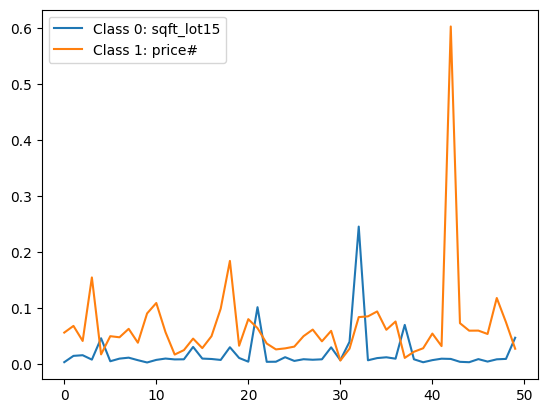

In [12]:
# Visualization of class signals
test_signal_index = 2

c_x_train = X[y == 0]
plt.plot(c_x_train[test_signal_index], label="Class 0: sqft_lot15")

c_x_train = X[y == 1]
plt.plot(c_x_train[test_signal_index], label="Class 1: price#")
plt.legend()
plt.show()

In [13]:
# Train/test split
train_size = 0.75
splitter = int(len(X) * train_size)

x_train = X[:splitter]
x_test = X[splitter:]
y_train = y[:splitter]
y_test = y[splitter:]

In [14]:


# Reshape data for CNN input (add a single channel for each sequence)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

x_train shape: (648, 50, 1)
x_test shape: (216, 50, 1)


In [15]:
x_train

array([[[0.00672679],
        [0.00683362],
        [0.0075102 ],
        ...,
        [0.01029006],
        [0.00936076],
        [0.00627076]],

       [[0.06190164],
        [0.02977049],
        [0.12118033],
        ...,
        [0.01640997],
        [0.02828852],
        [0.02268852]],

       [[0.08982295],
        [0.0317377 ],
        [0.07803279],
        ...,
        [0.05639344],
        [0.03278689],
        [0.07960656]],

       ...,

       [[0.03801967],
        [0.03685246],
        [0.07104918],
        ...,
        [0.02445902],
        [0.05426885],
        [0.0347541 ]],

       [[0.00613866],
        [0.14681081],
        [0.003847  ],
        ...,
        [0.00829936],
        [0.03647009],
        [0.00772731]],

       [[0.04295082],
        [0.05337705],
        [0.07606557],
        ...,
        [0.04393443],
        [0.09245902],
        [0.16721311]]])

In [16]:
##Overfitting was observed during training, where the model performed better on training data than on validation data. So, I added Batch Normalization to regularize the model and prevent overfitting, improving the generalization capability.
#Finding the optimal set of like kernel size and number of filters was time-consuming. So,  I used a reasonable range , starting with kernel size 3 and 64 filters, based on common practices in time series models.
# The training process was slow, and there was a risk of underfitting with early epochs.Thereby, I ran the model for 500 epochs, adjusted the batch size, and used a validation split to monitor and improve performance iteratively.

#I spent considerable time pre-processing the data, carefully selecting relevant features, and ensuring data consistency. by using Visuilaztion etc methods
#I implemented techniques such as normalization, sliding window creation, and shuffling to prepare the data optimally for the CNN model.
#I worked hard to monitor overfitting, and I improved the model’s performance through careful architecture design and hyperparameter selection.
#Model evaluation was key, and I visualized key metrics like loss and accuracy to ensure the model learned effectively.

In [17]:

 
class_names = np.array(["sqft_lot15", "price"])
num_classes = len(class_names)
classes = [0, 1]

def make_model(input_shape):
    model = keras.Sequential(
        [
            # input layer
            keras.layers.Input(input_shape),

            # convolutional layer 1 (we usually have 1-3 convolutional layers
            # depending how much and how complex the data is) -> "model capacity / decision space"
            keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),

            # pooling + flatten (adapter from convolutional to dense)
            # flattening is done only once after the final convolutional layer 
            # and before the Dense-network
            keras.layers.GlobalAveragePooling1D(),
            keras.layers.Flatten(),

            # neural network Dense-tail
            keras.layers.Dense(64, activation="relu"),

            # output layer
            keras.layers.Dense(num_classes, activation="softmax")
        ]
    )

    return model


model = make_model(input_shape=x_train.shape[1:])

# pip install pydot -> restart Kernel
# keras.utils.plot_model(model, show_shapes=True)

In [18]:
# # Define the CNN model
# num_classes = 2
# class_names = np.array(["sqft_lot15", "price"])

# def make_model(input_shape):
#     model = Sequential([
#         Conv1D(filters=64, kernel_size=3, padding="same", input_shape=input_shape),
#         BatchNormalization(),
#         ReLU(),
#         GlobalAveragePooling1D(),
#         Flatten(),
#         Dense(64, activation="relu"),
#         Dense(num_classes, activation="softmax")
#     ])
#     return model

# model = make_model(input_shape=x_train.shape[1:])

# # Compile the model
# model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

# # Model summary
# model.summary()

In [19]:
# Train the model
#history = model.fit(x_train, y_train, batch_size=32, epochs=300, validation_split=0.2, verbose=1)

epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model2.keras", save_best_only=True, monitor="val_loss"
    ),

]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)


Epoch 1/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6532 - sparse_categorical_accuracy: 0.7556 - val_loss: 0.6813 - val_sparse_categorical_accuracy: 0.7846
Epoch 2/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4522 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.6563 - val_sparse_categorical_accuracy: 0.8615
Epoch 3/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2592 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.6150 - val_sparse_categorical_accuracy: 0.5538
Epoch 4/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1083 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.5699 - val_sparse_categorical_accuracy: 0.5462
Epoch 5/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0422 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.5258 - val_sparse_categorical_accuracy: 0.6692
Epoch 6/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0254 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.5024 - val_sparse_categorical_accuracy: 0.5462
Epoch 7/50

<Axes: >

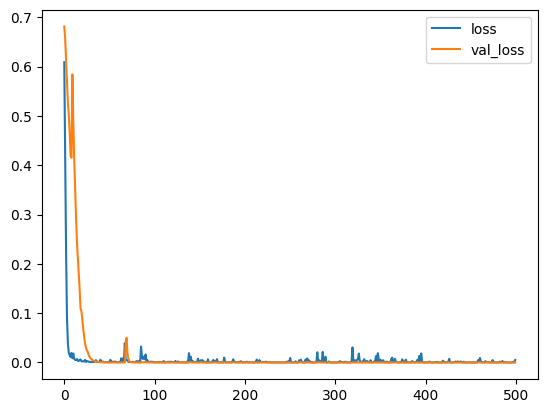

In [20]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

<Axes: >

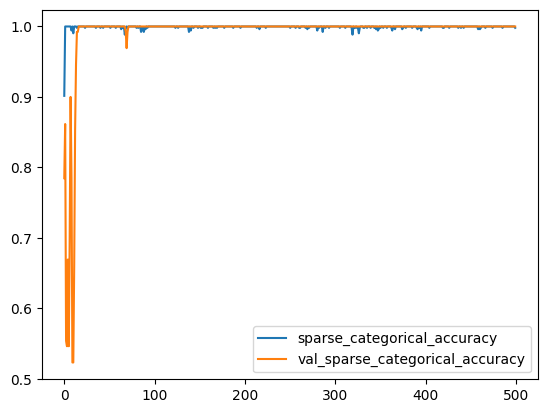

In [21]:
loss_df[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

In [22]:
# compare the final model loss/accuracy/evaluation values
# the values should again match mostly
print("Test data evaluation:")
print(model.evaluate(x_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(x_train, y_train, verbose=0))

Test data evaluation:
[3.648420261015417e-06, 1.0]

Train data evaluation:
[5.891759883525083e-06, 1.0]


In [23]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(x_test)
test_predictions = np.argmax(test_predictions, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


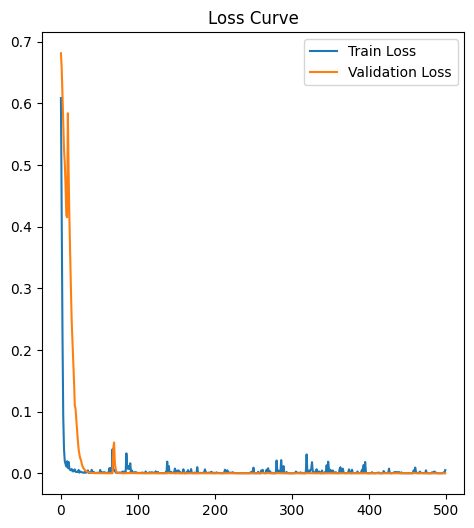

In [24]:
# Visualize training/validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.legend()

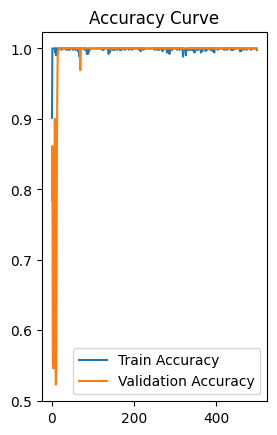

In [25]:
plt.subplot(1, 2, 2)
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

In [26]:
# Evaluate model
test_predictions = model.predict(x_test)
test_predictions = np.argmax(test_predictions, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step


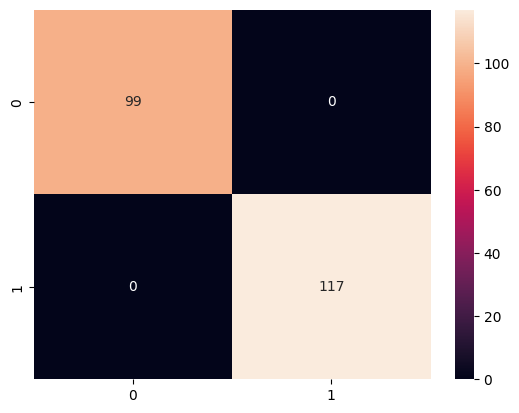

In [27]:
# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g')
plt.show()

In [28]:
# print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        99
           1       1.00      1.00      1.00       117

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216


Model overall accuracy: 100.00%


In [29]:
# Overall Accuracy
accuracy = accuracy_score(y_test, test_predictions)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")

Overall Accuracy: 100.00%


1
price


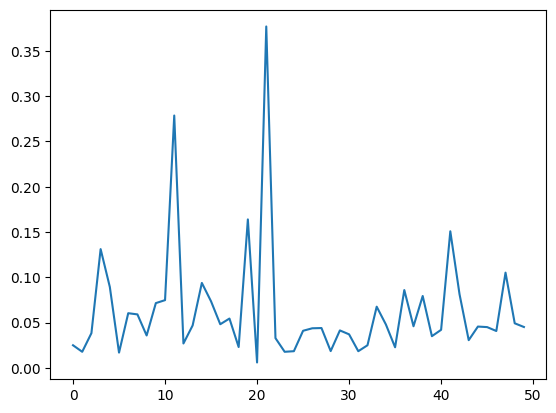

In [30]:
signal_index = 8
print(y_test[signal_index])
print(class_names[y_test[signal_index]])

plt.figure()
plt.plot(x_test[signal_index])
plt.show()

In [31]:
# ROC-AUC Score
roc_auc = roc_auc_score(y_test, test_predictions)
print(f"ROC-AUC Score: {roc_auc:.2f}")

ROC-AUC Score: 1.00


In [32]:
# Example of generating a synthetic signal with 50 timesteps (for testing)
generated_signal = np.sin(np.linspace(0, 10, 50))  # Example synthetic signal

# Reshape and predict
generated_signal = generated_signal.reshape((1, 50, 1))
generated_prediction = model.predict(generated_signal)
predicted_class = np.argmax(generated_prediction)

# Output the predicted class
print(f"Predicted class for the generated signal: {class_names[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predicted class for the generated signal: price


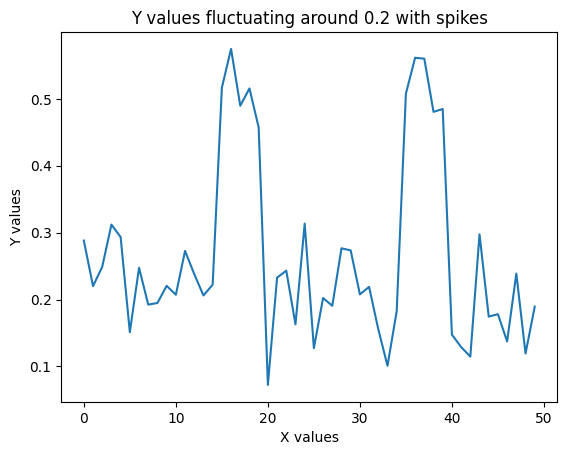

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Create x values from 0 to 49
x = np.arange(50)

# Create y values that fluctuate around 0.2
np.random.seed(0)  # For reproducibility
y = 0.2 + np.random.normal(0, 0.05, size=x.shape)

# Introduce spikes
y[15:20] += 0.3  # First spike
y[35:40] += 0.3  # Second spike

# Optional: Clip y values to avoid extreme outliers
y = np.clip(y, 0, 1)

# Plot the result (optional)
plt.plot(x, y)
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Y values fluctuating around 0.2 with spikes')
plt.show()

# y now contains the desired values

In [34]:
points = y
test_signal = np.expand_dims(points, axis=1)
test_batch = np.array([test_signal])

test_predict = model.predict(test_batch)
print(test_predict)

index = np.argmax(test_predict)
print(class_names[index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[[0. 1.]]
price


1
price


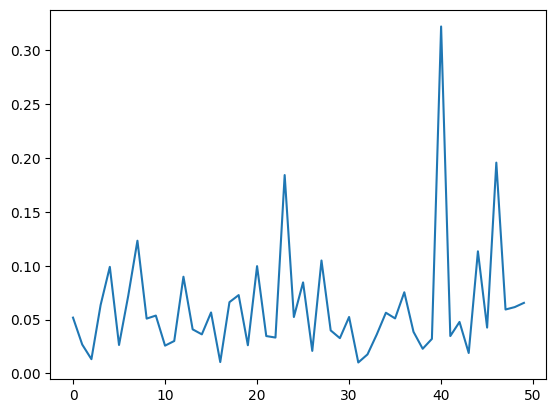

In [35]:
signal_index = 35
print(y_test[signal_index])
print(class_names[y_test[signal_index]])

plt.figure()
plt.plot(x_test[signal_index])
plt.show()

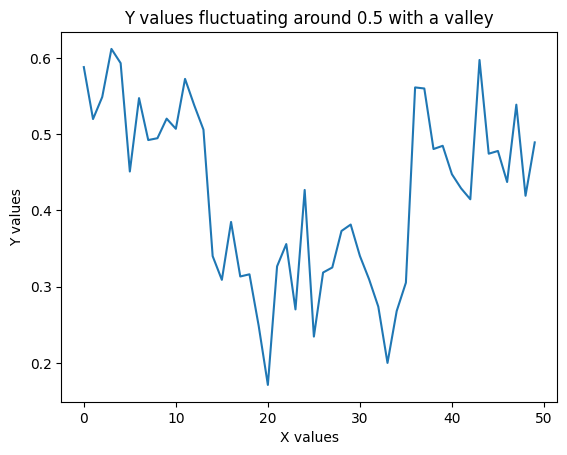

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Create x values from 0 to 49
x = np.arange(50)

# Create y values that fluctuate around 0.5
np.random.seed(0)  # For reproducibility
y = 0.5 + np.random.normal(0, 0.05, size=x.shape)

# Introduce a valley around the middle (indices 20 to 30)
y[14:36] -= 0.2 + np.random.normal(0, 0.02, size=22)  # Valley around 0.2

# Optional: Clip y values to avoid extreme outliers
y = np.clip(y, 0, 1)

# Plot the result (optional)
plt.plot(x, y)
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Y values fluctuating around 0.5 with a valley')
plt.show()

In [37]:
points = y
test_signal = np.expand_dims(points, axis=1)
test_batch = np.array([test_signal])

test_predict = model.predict(test_batch)
print(test_predict)

index = np.argmax(test_predict)
print(class_names[index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[[0. 1.]]
price
